In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stat

pd.set_option('display.max_columns', 500)
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install plotly-geo

import plotly.figure_factory as ff

### Does patient race/gender predict receiving pain meds?

In [2]:
pts = pd.read_csv('eicu-collaborative-research-database-2.0/patient.csv.gz')
dxs = pd.read_csv('eicu-collaborative-research-database-2.0/diagnosis.csv.gz')
tm = pd.read_csv('eicu-collaborative-research-database-2.0/treatment.csv.gz')
hos = pd.read_csv('eicu-collaborative-research-database-2.0/hospital.csv.gz')
cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

In [3]:
tm['painmeds'] = tm['treatmentstring'].str.contains('analgesics', case = False)
tm = tm[tm.painmeds == True]

tm.drop_duplicates(subset='patientunitstayid', inplace=True)
tm.drop(['treatmentid','treatmentoffset', 'activeupondischarge'], axis=1, inplace=True)

In [4]:
tm.head()

,patientunitstayid,treatmentstring,painmeds
76,242070,neurologic|pain / agitation / altered mentatio...,True
123,242083,neurologic|pain / agitation / altered mentatio...,True
176,242154,neurologic|pain / agitation / altered mentatio...,True
255,242319,neurologic|pain / agitation / altered mentatio...,True
342,242380,neurologic|pain / agitation / altered mentatio...,True


In [5]:
# create dictionary of all patient IDs that received pain meds & their treatment
pm_dict = dict(zip(tm.patientunitstayid, tm.painmeds))
tm_dict = dict(zip(tm.patientunitstayid, tm.treatmentstring))

# mapping hospital region to id
region = dict(zip(hos.hospitalid, hos.region))
size = dict(zip(hos.hospitalid, hos.numbedscategory))

In [6]:
def pain_val (x, dic):
    if x in dic:
        return True
    else:
        return False
    
def get_tm (x, dic):
    if x in dic:
        return dic[x]
    else:
        return "No pain medications"
    
def get_region (x, dic):
    if x in dic:
        return dic[x]
    else:
        return np.nan

In [7]:
pts['pain_meds'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, pm_dict))
pts['tm_string'] = pts['patientunitstayid'].apply(lambda x: get_tm(x, tm_dict))

pts['hospitalregion'] = pts['hospitalid'].apply(lambda x: get_region(x, region))
pts['hospitalsize'] = pts['hospitalid'].apply(lambda x: get_region(x, size))

pts = pts[pts.gender != 'Unknown']
pts = pts[pts.gender != 'Other']

pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,pain_meds,tm_string,hospitalregion,hospitalsize
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,False,No pain medications,Midwest,<100
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,No pain medications,Midwest,<100
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,No pain medications,Midwest,<100
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,False,No pain medications,Midwest,>= 500
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,False,No pain medications,Midwest,NaN


In [8]:
pts_sub = pts[['gender','ethnicity', 'pain_meds', 'tm_string']]
pts_sub.head()

,gender,ethnicity,pain_meds,tm_string
0,Female,Caucasian,False,No pain medications
1,Female,Caucasian,False,No pain medications
2,Female,Caucasian,False,No pain medications
3,Male,Caucasian,False,No pain medications
4,Male,Caucasian,False,No pain medications


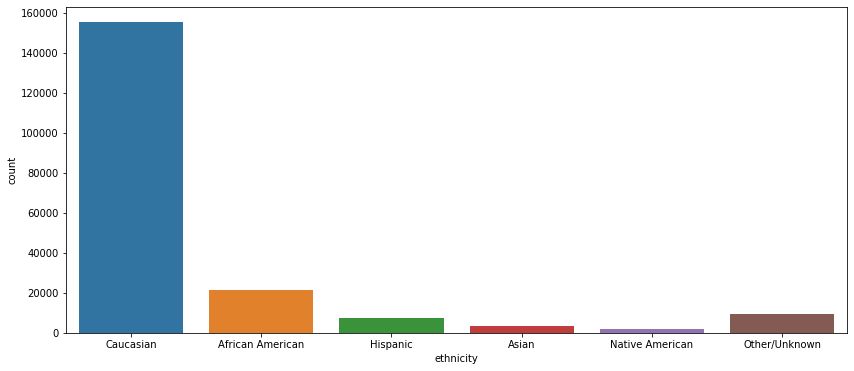

In [9]:
plt.figure(figsize=(14, 6))
sns.countplot(x='ethnicity',data=pts_sub)

In [10]:
pts_sub['ethnicity'].value_counts()

Caucasian           155273
African American     21303
Other/Unknown         9523
Hispanic              7462
Asian                 3270
Native American       1700
Name: ethnicity, dtype: int64

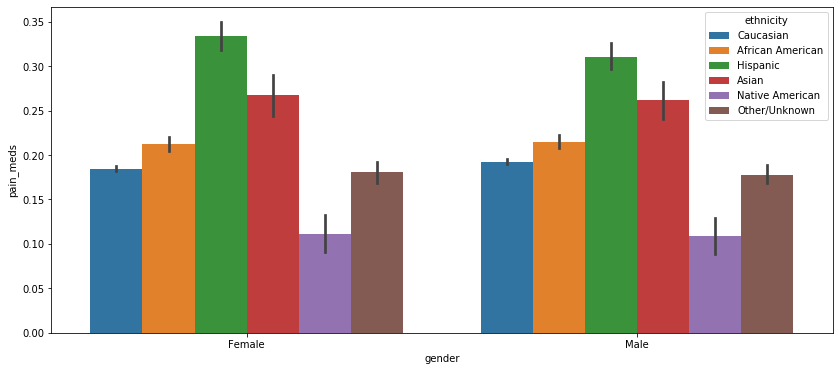

In [11]:
plt.figure(figsize=(14, 6))
sns.barplot(x='gender',y='pain_meds',hue='ethnicity',data=pts_sub, estimator=np.mean)

Distribution between gender looks the same, but but ethnicity is not. Chi Squared Test for independence (p < 0.01).

In [12]:
ct_eth = pd.crosstab(pts_sub.pain_meds, pts_sub.ethnicity, margins= True)
ct_eth

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,All
pain_meds,,,,,,,
False,16754,2404,125960,5064,1513,7818,159513
True,4549,866,29313,2398,187,1705,39018
All,21303,3270,155273,7462,1700,9523,198531


In [13]:
fobs = [16754, 2404, 125960, 5064, 1513, 7818]
ftots = [21303, 3270, 155273, 7462, 1700, 9523]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

Power_divergenceResult(statistic=202.44295590235217, pvalue=8.526351751144247e-42)

 - **Therefore, ethnicity and receiving pain medication are not independent.**

In [14]:
ct_gen = pd.crosstab(pts_sub.pain_meds, pts_sub.gender, margins= True)
ct_gen

gender,Female,Male,All
pain_meds,,,
False,74431,86787,161218
True,17872,21592,39464
All,92303,108379,200682


In [15]:
fobs = [74431, 86787]
ftots = [92303, 108379]
fexp = np.multiply(np.sum(fobs)/np.sum(ftots),ftots)
stat.chisquare(f_obs = fobs, f_exp = fexp)

Power_divergenceResult(statistic=1.9484240573566582, pvalue=0.1627567748149568)

- Therefore, gender and receiving pain medication is independent.
___

#### Logistic regression with just gender and ethnicity as features:

In [16]:
pts_log = pd.get_dummies(pts_sub,columns = ['gender', 'ethnicity'], drop_first = False)
pts_log = pts_log.drop(columns=['tm_string'])
pts_log.head()

,pain_meds,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,False,1,0,0,0,1,0,0,0
1,False,1,0,0,0,1,0,0,0
2,False,1,0,0,0,1,0,0,0
3,False,0,1,0,0,1,0,0,0
4,False,0,1,0,0,1,0,0,0


In [17]:
X = pts_log.drop(columns='pain_meds')
y = pts_log.pain_meds

In [19]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['pain_meds'])

# Check the numbers of our data
print("Original length of data:", len(X_train))
print("Number of no subscription (no pain meds) in data:", len(y_train)-sum(y_train))
print("Number of subscription (pain meds) in data:", sum(y_train))
print("Proportion of no subscription data in oversampled data is:",(len(y_train)-sum(y_train))/len(X_train))
print("Proportion of subscription data in oversampled data is:",sum(y_train)/len(X_train))
print("-----")
print("Length of oversampled data is:",len(os_data_X))
print("Number of no subscription (no pain meds) in oversampled data:",len(os_data_y[os_data_y['pain_meds']==0]))
print("Number of subscription (pain meds) in data:",len(os_data_y[os_data_y['pain_meds']==1]))
print("Proportion of no subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==1])/len(os_data_X))

Original length of data: 140571
Number of no subscription (no pain meds) in data: 112890
Number of subscription (pain meds) in data: 27681
Proportion of no subscription data in oversampled data is: 0.8030817167125509
Proportion of subscription data in oversampled data is: 0.19691828328744904
-----
Length of oversampled data is: 225780
Number of no subscription (no pain meds) in oversampled data: 112890
Number of subscription (pain meds) in data: 112890
Proportion of no subscription data in oversampled data is: 0.5
Proportion of subscription data in oversampled data is: 0.5


In [20]:
logit_model=sm.Logit(os_data_y,os_data_X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.689496
         Iterations 4
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.005      
Dependent Variable:    pain_meds           AIC:                 311364.7062
Date:                  2020-07-22 06:30    BIC:                 311447.3248
No. Observations:      225780              Log-Likelihood:      -1.5567e+05
Df Model:              7                   LL-Null:             -1.5650e+05
Df Residuals:          225772              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        4.0000                                              
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
gender_Female    

In [21]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [22]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


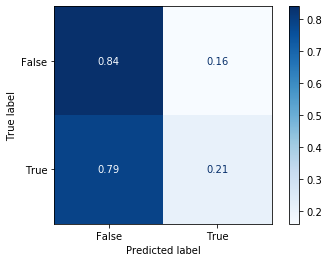

In [23]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.84      0.83     48451
        True       0.24      0.21      0.23     11794

    accuracy                           0.72     60245
   macro avg       0.53      0.53      0.53     60245
weighted avg       0.70      0.72      0.71     60245



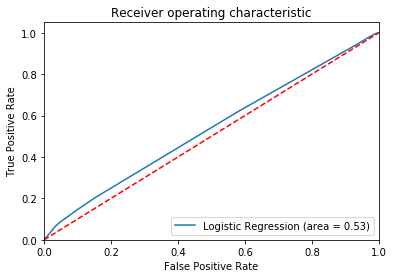

In [25]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Logistic regression with all variables:

In [26]:
pts.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,pain_meds,tm_string,hospitalregion,hospitalsize
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851,False,No pain medications,Midwest,<100
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870,False,No pain medications,Midwest,<100
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870,False,No pain medications,Midwest,<100
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276,False,No pain medications,Midwest,>= 500
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665,False,No pain medications,Midwest,NaN


In [27]:
pts['apacheadmissiondx'].fillna(value = 'N/A', inplace = True)
pts['hospitaladmitsource'].fillna(value = 'Unknown', inplace = True)
pts['age'].fillna(value = 0, inplace = True)

In [28]:
def age (x):
    if x == '> 89':
        return 90
    else:
        return int(x)

pts['age'] = pts['age'].apply(lambda x: age(x))

In [29]:
def get_hour (x):
    return x[0:2]

pts['hospitaladmittime24'] = pts['hospitaladmittime24'].apply(lambda x: get_hour(x))
pts['hospitaldischargetime24'] = pts['hospitaldischargetime24'].apply(lambda x: get_hour(x))
pts['unitadmittime24'] = pts['unitadmittime24'].apply(lambda x: get_hour(x))
pts['unitdischargetime24'] = pts['unitdischargetime24'].apply(lambda x: get_hour(x))

In [30]:
cat_cols = ['gender', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'hospitaladmitsource', 
            'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmitsource', 'unitvisitnumber',
           'unitstaytype', 'unitdischargelocation', 'unitdischargestatus', 'hospitalregion', 'hospitalsize']

pts_log = pd.get_dummies(pts, columns = cat_cols, drop_first = False)

In [31]:
X = pts_log.drop(columns=['pain_meds', 'tm_string', 'admissionweight', 'patientunitstayid', 'patienthealthsystemstayid', 
                         'uniquepid', 'dischargeweight', 'admissionheight'])
y = pts_log.pain_meds

In [32]:
X.head()

,age,hospitaladmittime24,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,unitdischargetime24,unitdischargeoffset,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospitalid_56,hospitalid_58,hospitalid_59,hospitalid_60,hospitalid_61,hospitalid_63,hospitalid_66,hospitalid_67,hospitalid_68,hospitalid_69,hospitalid_71,hospitalid_73,hospitalid_79,hospitalid_83,hospitalid_84,hospitalid_85,hospitalid_86,hospitalid_90,hospitalid_91,hospitalid_92,hospitalid_93,hospitalid_94,hospitalid_95,hospitalid_96,hospitalid_102,hospitalid_108,hospitalid_110,hospitalid_112,hospitalid_115,hospitalid_120,hospitalid_122,hospitalid_123,hospitalid_125,hospitalid_131,hospitalid_133,hospitalid_135,hospitalid_136,hospitalid_138,hospitalid_140,hospitalid_141,hospitalid_142,hospitalid_143,hospitalid_144,hospitalid_146,hospitalid_148,hospitalid_151,hospitalid_152,hospitalid_154,hospitalid_155,hospitalid_156,hospitalid_157,hospitalid_158,hospitalid_164,hospitalid_165,hospitalid_167,hospitalid_171,hospitalid_174,hospitalid_175,hospitalid_176,hospitalid_179,hospitalid_180,hospitalid_181,hospitalid_182,hospitalid_183,hospitalid_184,hospitalid_188,hospitalid_194,hospitalid_195,hospitalid_196,hospitalid_197,hospitalid_198,hospitalid_199,hospitalid_200,hospitalid_201,hospitalid_202,hospitalid_203,hospitalid_204,hospitalid_205,hospitalid_206,hospitalid_207,hospitalid_208,hospitalid_209,hospitalid_210,hospitalid_212,hospitalid_215,hospitalid_217,hospitalid_220,hospitalid_224,hospitalid_226,hospitalid_227,hospitalid_243,hospitalid_244,hospitalid_245,hospitalid_246,hospitalid_248,hospitalid_249,hospitalid_250,hospitalid_251,hospitalid_252,hospitalid_253,hospitalid_254,hospitalid_256,hospitalid_258,hospitalid_259,hospitalid_262,hospitalid_263,hospitalid_264,hospitalid_265,hospitalid_266,hospitalid_267,hospitalid_268,hospitalid_269,hospitalid_271,hospitalid_272,hospitalid_273,hospitalid_275,hospitalid_277,hospitalid_279,hospitalid_280,hospitalid_281,hospitalid_282,hospitalid_283,hospitalid_300,hospitalid_301,hospitalid_303,hospitalid_307,hospitalid_310,hospitalid_312,hospitalid_318,hospitalid_323,hospitalid_328,hospitalid_331,hospitalid_336,hospitalid_337,hospitalid_338,hospitalid_342,hospitalid_345,hospitalid_350,hospitalid_351,hospitalid_352,hospitalid_353,hospitalid_355,hospitalid_356,hospitalid_357,hospitalid_358,hospitalid_360,hospitalid_361,hospitalid_363,hospitalid_364,hospitalid_365,hospitalid_381,hospitalid_382,hospitalid_383,hospitalid_384,hospitalid_385,hospitalid_386,hospitalid_387,hospitalid_388,hospitalid_389,hospitalid_390,hospitalid_391,hospitalid_392,hospitalid_393,hospitalid_394,hospitalid_396,hospitalid_397,hospitalid_398,hospitalid_399,hospitalid_400,hospitalid_401,hospitalid_402,hospitalid_403,hospitalid_404,hospitalid_405,hospitalid_407,hospitalid_408,hospitalid_409,hospitalid_411,hospitalid_412,hospitalid_413,hospitalid_414,hospitalid_416,hospitalid_417,hospitalid_419,hospitalid_420,hospitalid_421,hospitalid_422,hospitalid_423,hospitalid_424,hospitalid_425,hospitalid_428,hospitalid_429,hospitalid_433,hospitalid_434,hospitalid_435,hospitalid_436,hospitalid_437,hospitalid_438,hospitalid_439,hospitalid_440,hospitalid_443,hospitalid_444,hospitalid_445,hospitalid_447,hospitalid_449,hospitalid_452,hospitalid_458,hospitalid_459,wardid_82,wardid_83,wardid_85,wardid_87,wardid_89,wardid_90,wardid_91,wardid_92,wardid_93,wardid_95,wardid_97,wardid_98,wardid_99,wardid_100,wardid_102,wardid_103,wardid_108,wardid_109,wardid_113,wardid_114,wardid_120,wardid_123,wardid_125,wardid_126,wardid_133,...,"apacheadmissiondx_Leukemia, other",apacheadmissiondx_Liver transplant,"apacheadmissiondx_Lung transplant, bilateral","apacheadmissiondx_Lung transplant, single","apacheadmissiondx_Lupus, systemic","apacheadmissiondx_Lymph node dissection, pelvic or retroperitoneal (female)","apacheadmissiondx_Lymph node dis

In [33]:
X.columns[X.isnull().any()]

Index([], dtype='object')

In [34]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['pain_meds'])

# Check the numbers of our data
print("Original length of data:", len(X_train))
print("Number of no subscription (no pain meds) in data:", len(y_train)-sum(y_train))
print("Number of subscription (pain meds) in data:", sum(y_train))
print("Proportion of no subscription data in oversampled data is:",(len(y_train)-sum(y_train))/len(X_train))
print("Proportion of subscription data in oversampled data is:",sum(y_train)/len(X_train))
print("-----")
print("Length of oversampled data is:",len(os_data_X))
print("Number of no subscription (no pain meds) in oversampled data:",len(os_data_y[os_data_y['pain_meds']==0]))
print("Number of subscription (pain meds) in data:",len(os_data_y[os_data_y['pain_meds']==1]))
print("Proportion of no subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==1])/len(os_data_X))

Original length of data: 140571
Number of no subscription (no pain meds) in data: 112890
Number of subscription (pain meds) in data: 27681
Proportion of no subscription data in oversampled data is: 0.8030817167125509
Proportion of subscription data in oversampled data is: 0.19691828328744904
-----
Length of oversampled data is: 225780
Number of no subscription (no pain meds) in oversampled data: 112890
Number of subscription (pain meds) in data: 112890
Proportion of no subscription data in oversampled data is: 0.5
Proportion of subscription data in oversampled data is: 0.5


In [35]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [36]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.65


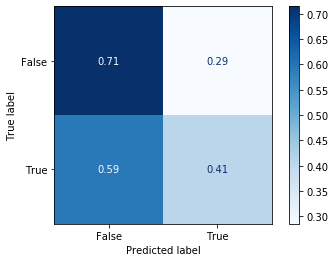

In [37]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.71      0.77     48451
        True       0.26      0.41      0.32     11794

    accuracy                           0.65     60245
   macro avg       0.54      0.56      0.54     60245
weighted avg       0.72      0.65      0.68     60245



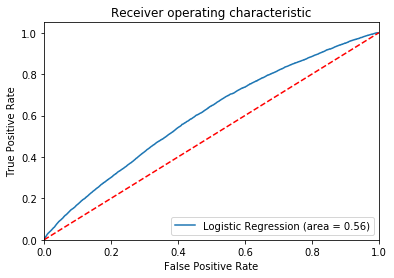

In [39]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Notes:
 - This is still just a first pass and could potentially be improved by imputing some of missing values instad of removing them completely (notably height and weight).
 - Adding several other features including hospital region didnt really make a difference.
 ___

In [40]:
nsc = pd.read_csv('eicu-collaborative-research-database-2.0/nurseCharting.csv.gz')

In [41]:
nsc.drop(['nursingchartid','nursingchartoffset', 'nursingchartentryoffset', 
          'nursingchartcelltypecat', 'nursingchartcelltypevallabel'], axis=1, inplace=True)
nsc = nsc[nsc['nursingchartcelltypevalname'] == 'Pain Score']

In [42]:
nsc.patientunitstayid.value_counts()

199499     3389
3172552    1315
3114528    1305
3074177    1265
3146941    1252
           ... 
1478822       1
1067133       1
1072421       1
1070816       1
156618        1
Name: patientunitstayid, Length: 76400, dtype: int64

In [43]:
nsc.head()

,patientunitstayid,nursingchartcelltypevalname,nursingchartvalue
7,141924,Pain Score,2
16,141924,Pain Score,2
40,141924,Pain Score,5
71,141924,Pain Score,3
105,141924,Pain Score,3


In [44]:
nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: float(x))

In [45]:
valid = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
nsc = nsc[nsc['nursingchartvalue'].isin(valid)]

In [46]:
nsc['nursingchartvalue'] = nsc['nursingchartvalue'].apply(lambda x: int(x))
nsc.drop(['nursingchartcelltypevalname'], axis=1, inplace=True)

In [47]:
max_pain = nsc.groupby('patientunitstayid').max()
mean_pain = nsc.groupby('patientunitstayid').mean()

In [91]:
def pain_val (x, arr):
    try:
        return round(arr['nursingchartvalue'][x])
    except:
        return np.nan

In [92]:
pts_log['max_pain'] = pts_log['patientunitstayid'].apply(lambda x: pain_val(x, max_pain))
pts['max_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, max_pain))

pts_log['mean_pain'] = pts_log['patientunitstayid'].apply(lambda x: pain_val(x, mean_pain))
pts['mean_pain'] = pts['patientunitstayid'].apply(lambda x: pain_val(x, mean_pain))

In [93]:
pts_log.head()

,patientunitstayid,patienthealthsystemstayid,age,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,uniquepid,pain_meds,tm_string,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospitalid_56,hospitalid_58,hospitalid_59,hospitalid_60,hospitalid_61,hospitalid_63,hospitalid_66,hospitalid_67,hospitalid_68,hospitalid_69,hospitalid_71,hospitalid_73,hospitalid_79,hospitalid_83,hospitalid_84,hospitalid_85,hospitalid_86,hospitalid_90,hospitalid_91,hospitalid_92,hospitalid_93,hospitalid_94,hospitalid_95,hospitalid_96,hospitalid_102,hospitalid_108,hospitalid_110,hospitalid_112,hospitalid_115,hospitalid_120,hospitalid_122,hospitalid_123,hospitalid_125,hospitalid_131,hospitalid_133,hospitalid_135,hospitalid_136,hospitalid_138,hospitalid_140,hospitalid_141,hospitalid_142,hospitalid_143,hospitalid_144,hospitalid_146,hospitalid_148,hospitalid_151,hospitalid_152,hospitalid_154,hospitalid_155,hospitalid_156,hospitalid_157,hospitalid_158,hospitalid_164,hospitalid_165,hospitalid_167,hospitalid_171,hospitalid_174,hospitalid_175,hospitalid_176,hospitalid_179,hospitalid_180,hospitalid_181,hospitalid_182,hospitalid_183,hospitalid_184,hospitalid_188,hospitalid_194,hospitalid_195,hospitalid_196,hospitalid_197,hospitalid_198,hospitalid_199,hospitalid_200,hospitalid_201,hospitalid_202,hospitalid_203,hospitalid_204,hospitalid_205,hospitalid_206,hospitalid_207,hospitalid_208,hospitalid_209,hospitalid_210,hospitalid_212,hospitalid_215,hospitalid_217,hospitalid_220,hospitalid_224,hospitalid_226,hospitalid_227,hospitalid_243,hospitalid_244,hospitalid_245,hospitalid_246,hospitalid_248,hospitalid_249,hospitalid_250,hospitalid_251,hospitalid_252,hospitalid_253,hospitalid_254,hospitalid_256,hospitalid_258,hospitalid_259,hospitalid_262,hospitalid_263,hospitalid_264,hospitalid_265,hospitalid_266,hospitalid_267,hospitalid_268,hospitalid_269,hospitalid_271,hospitalid_272,hospitalid_273,hospitalid_275,hospitalid_277,hospitalid_279,hospitalid_280,hospitalid_281,hospitalid_282,hospitalid_283,hospitalid_300,hospitalid_301,hospitalid_303,hospitalid_307,hospitalid_310,hospitalid_312,hospitalid_318,hospitalid_323,hospitalid_328,hospitalid_331,hospitalid_336,hospitalid_337,hospitalid_338,hospitalid_342,hospitalid_345,hospitalid_350,hospitalid_351,hospitalid_352,hospitalid_353,hospitalid_355,hospitalid_356,hospitalid_357,hospitalid_358,hospitalid_360,hospitalid_361,hospitalid_363,hospitalid_364,hospitalid_365,hospitalid_381,hospitalid_382,hospitalid_383,hospitalid_384,hospitalid_385,hospitalid_386,hospitalid_387,hospitalid_388,hospitalid_389,hospitalid_390,hospitalid_391,hospitalid_392,hospitalid_393,hospitalid_394,hospitalid_396,hospitalid_397,hospitalid_398,hospitalid_399,hospitalid_400,hospitalid_401,hospitalid_402,hospitalid_403,hospitalid_404,hospitalid_405,hospitalid_407,hospitalid_408,hospitalid_409,hospitalid_411,hospitalid_412,hospitalid_413,hospitalid_414,hospitalid_416,hospitalid_417,hospitalid_419,hospitalid_420,hospitalid_421,hospitalid_422,hospitalid_423,hospitalid_424,hospitalid_425,hospitalid_428,hospitalid_429,hospitalid_433,hospitalid_434,hospitalid_435,hospitalid_436,hospitalid_437,hospitalid_438,hospitalid_439,hospitalid_440,hospitalid_443,hospitalid_444,hospitalid_445,hospitalid_447,hospitalid_449,hospitalid_452,hospitalid_458,hospitalid_459,wardid_82,wardid_83,wardid_85,wardid_87,wardid_89,wardid_90,wardid_91,wardid_92,wardid_93,wardid_95,wardid_97,wardid_98,wardid_99,wardid_100,wardid_102,wardid_103,wardid_108,...,"apacheadmissiondx_Lung transplant, bilateral","apacheadmissiondx_Lung transplant, single","apacheadmissiondx_Lupus, systemic","apacheadmissiondx_Lymph node dissection, pelvic or retroperitoneal (female)","apacheadmissiondx_Lymph node dissection, pelvic or retroperitoneal (m

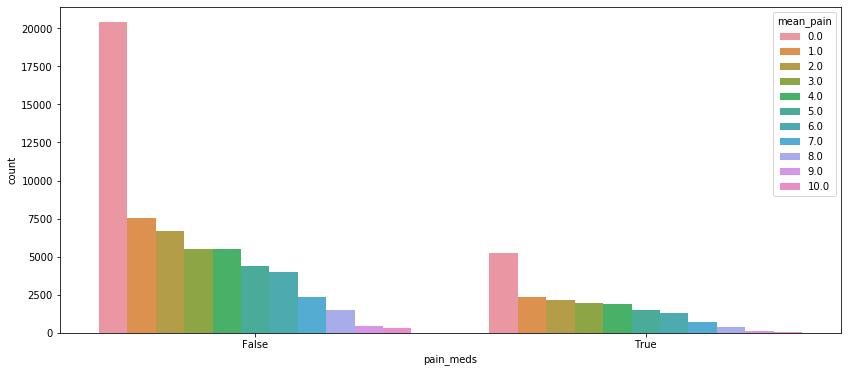

In [94]:
plt.figure(figsize=(14, 6))
sns.countplot(x='pain_meds', hue='mean_pain', data=pts_log)

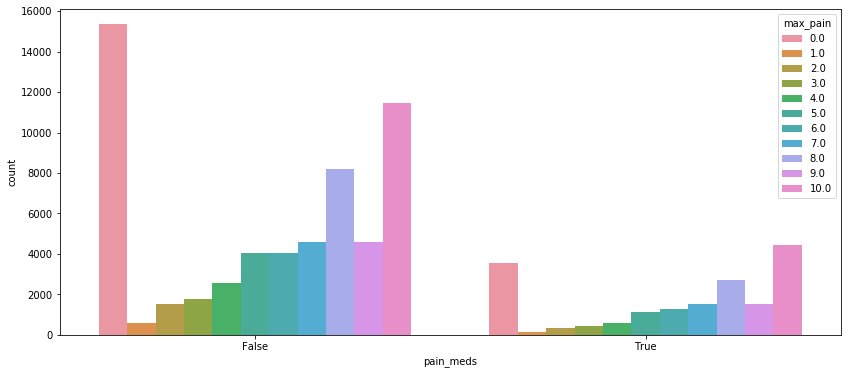

In [95]:
plt.figure(figsize=(14, 6))
sns.countplot(x='pain_meds', hue='max_pain', data=pts_log)

About 62% of the pain scores are missing so they wouldn't be a viable metric?

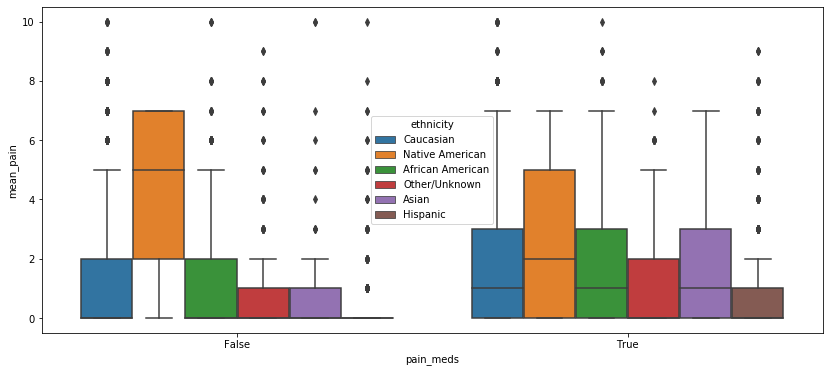

In [96]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='pain_meds',y='mean_pain',hue='ethnicity',data=pts)

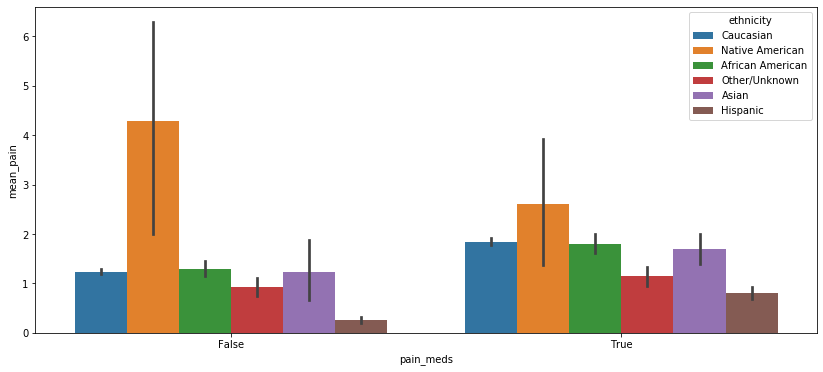

In [97]:
plt.figure(figsize=(14, 6))
sns.barplot(x='pain_meds',y='mean_pain',hue='ethnicity',data=pts)

In [98]:
pts_drops = pts_log.dropna()

X = pts_drops.drop(columns=['pain_meds', 'tm_string', 'admissionweight', 'patientunitstayid', 'patienthealthsystemstayid', 
                         'uniquepid'])
y = pts_drops.pain_meds

In [99]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['pain_meds'])

# Check the numbers of our data
print("Original length of data:", len(X_train))
print("Number of no subscription (no pain meds) in data:", len(y_train)-sum(y_train))
print("Number of subscription (pain meds) in data:", sum(y_train))
print("Proportion of no subscription data in oversampled data is:",(len(y_train)-sum(y_train))/len(X_train))
print("Proportion of subscription data in oversampled data is:",sum(y_train)/len(X_train))
print("-----")
print("Length of oversampled data is:",len(os_data_X))
print("Number of no subscription (no pain meds) in oversampled data:",len(os_data_y[os_data_y['pain_meds']==0]))
print("Number of subscription (pain meds) in data:",len(os_data_y[os_data_y['pain_meds']==1]))
print("Proportion of no subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is:",len(os_data_y[os_data_y['pain_meds']==1])/len(os_data_X))

Original length of data: 37282
Number of no subscription (no pain meds) in data: 28654
Number of subscription (pain meds) in data: 8628
Proportion of no subscription data in oversampled data is: 0.7685746472828711
Proportion of subscription data in oversampled data is: 0.2314253527171289
-----
Length of oversampled data is: 57308
Number of no subscription (no pain meds) in oversampled data: 28654
Number of subscription (pain meds) in data: 28654
Proportion of no subscription data in oversampled data is: 0.5
Proportion of subscription data in oversampled data is: 0.5


In [100]:
logreg = LogisticRegression()
logreg.fit(os_data_X, os_data_y)

/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/adeshkadambi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [101]:
os_data_X.columns

Index(['age', 'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaldischargeyear', 'hospitaldischargetime24',
       'hospitaldischargeoffset', 'unitadmittime24', 'dischargeweight',
       'unitdischargetime24',
       ...
       'hospitalregion_Midwest', 'hospitalregion_Northeast',
       'hospitalregion_South', 'hospitalregion_West', 'hospitalsize_100 - 249',
       'hospitalsize_250 - 499', 'hospitalsize_<100', 'hospitalsize_>= 500',
       'max_pain', 'mean_pain'],
      dtype='object', length=1055)

In [102]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.60


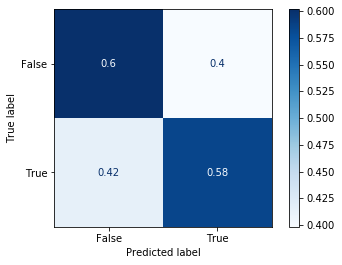

In [103]:
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.60      0.70     12259
        True       0.31      0.58      0.40      3720

    accuracy                           0.60     15979
   macro avg       0.57      0.59      0.55     15979
weighted avg       0.71      0.60      0.63     15979



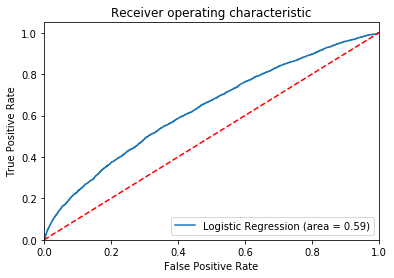

In [105]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ROCAUC Results:
- Just gender and ethnicity : 0.53
- All variables : 0.56
- Added pain scores : 0.59

___
Adding icd9 scores

In [65]:
dxs = pd.read_csv('eicu-collaborative-research-database-2.0/diagnosis.csv.gz')

In [66]:
dxs.drop_duplicates(subset=['patientunitstayid','diagnosispriority'],inplace=True)
dxs = dxs.drop(columns=['diagnosisid', 'activeupondischarge', 'diagnosisoffset', 'diagnosisstring'])
dxs.dropna(inplace=True)

In [67]:
dxs = dxs.groupby('patientunitstayid')['icd9code'].apply(list).reset_index(name='icd9codes')
dxs.head()

,patientunitstayid,icd9codes
0,141168,"[414.00, I25.10, 427.31, I48.0]"
1,141227,"[038.9, A41.9]"
2,141229,"[427.31, I48.0, 428.1, I50.1, 780.09, R41.82]"
3,141266,"[456.0, I85.01, 410.71, I21.4]"
4,141284,"[511.9, J91.8]"


In [68]:
pts = pd.merge(pts, dxs, on=['patientunitstayid'])

___
Adding Ordered Protocols

In [69]:
cpg = pd.read_csv('eicu-collaborative-research-database-2.0/carePlanGeneral.csv.gz')

In [70]:
cpg.head()

,cplgeneralid,patientunitstayid,activeupondischarge,cplitemoffset,cplgroup,cplitemvalue
0,4021595,141168,False,1846,Airway,Not intubated/normal airway
1,3519292,141168,True,1450,DVT Prophylaxis,Combined device and drug therapy
2,3997297,141168,True,2160,Ventilation,Ventilated - with daily extubation evaluation
3,3732045,141168,True,2244,Stress Ulcer Prophylaxis,Proton pump inhibitor
4,3522606,141168,False,74,Airway,Not intubated/normal airway


In [71]:
cpg = cpg[cpg.cplgroup == 'Ordered Protocols']
cpg.drop(columns=['cplgeneralid', 'activeupondischarge', 'cplitemoffset', 'cplgroup'], inplace = True)
cpg.drop_duplicates(inplace=True)

In [72]:
cpg = cpg.groupby('patientunitstayid')['cplitemvalue'].apply(list).reset_index(name='orderedprotocols')
cpg.head()

,patientunitstayid,orderedprotocols
0,154752,[Tissue Plasminogen Activator (tPA)]
1,156771,[Tissue Plasminogen Activator (tPA)]
2,173247,[Tissue Plasminogen Activator (tPA)]
3,196674,[Tissue Plasminogen Activator (tPA)]
4,196675,[Tissue Plasminogen Activator (tPA)]


In [73]:
pts = pd.merge(pts, cpg, on=['patientunitstayid'])

In [115]:
pts.head(6)

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,pain_meds,tm_string,hospitalregion,hospitalsize,max_pain,mean_pain,icd9codes,orderedprotocols
0,156771,140989,Female,88,Caucasian,63,95,"CVA, cerebrovascular accident/stroke",152.4,17,-14,Direct Admit,2014,18,14457,Skilled Nursing Facility,Alive,Med-Surg ICU,17,Direct Admit,1,admit,64.6,74.9,05,724,Floor,Alive,002-27764,False,No pain medications,Midwest,100 - 249,8.0,3.0,"[585.9, N18.9, 434.91, I63.50]",[Tissue Plasminogen Activator (tPA)]
1,211851,183825,Female,48,Caucasian,59,91,"Thrombosis, vascular (deep vein)",170.2,22,-1561,Emergency Department,2015,19,4064,Home,Alive,Med-Surg ICU,00,Floor,1,admit,68.4,72.3,15,2331,Floor,Alive,002-15063,False,No pain medications,Midwest,<100,6.0,3.0,"[451.2, I80.3]",[Tissue Plasminogen Activator (tPA)]
2,222815,192329,Female,68,Caucasian,73,89,"CVA, cerebrovascular accident/stroke",160.0,00,-71,Direct Admit,2014,16,9514,Skilled Nursing Facility,Alive,Neuro ICU,01,Direct Admit,1,admit,90.8,88.6,00,2824,Floor,Alive,002-67816,False,No pain medications,Midwest,>= 500,0.0,0.0,"[434.91, I63.50]",[Tissue Plasminogen Activator (tPA)]
3,228110,196429,Male,64,Caucasian,58,108,"Infarction, acute myocardial (MI)",165.1,18,-114,Emergency Department,2015,16,2605,Home,Alive,Med-Surg ICU,20,Emergency Department,1,admit,92.5,92.5,15,1129,Step-Down Unit (SDU),Alive,002-35679,False,No pain medications,Midwest,100 - 249,4.0,1.0,"[786.50, R07.9, 410.71, I21.4]",[Other]
4,234817,201651,Female,60,Caucasian,67,109,"Sepsis, pulmonary",170.2,20,-4387,Floor,2015,04,356,Other Hospital,Alive,Med-Surg ICU,22,Floor,1,admit,76.7,76.7,03,352,Other Hospital,Alive,002-16965,False,No pain medications,Midwest,NaN,10.0,5.0,"[038.9, A41.9, 996.84, T86.819, 486, J18.9]",[Ventilator bundle]
5,242319,207482,Male,61,Caucasian,79,133,"Sepsis, other",172.7,15,0,Direct Admit,2014,18,5896,Home,Alive,Med-Surg ICU,15,Direct Admit,1,admit,60.6,59.5,22,1856,Floor,Alive,003-58722,True,neurologic|pain / agitation / altered mentatio...,Midwest,>= 500,NaN,NaN,"[038.9, A41.9]",[Sepsis bundle]


Missing pain values

In [111]:
max_eth_vals = pts.groupby(['ethnicity'])['max_pain'].mean()
mean_eth_vals = pts.groupby(['ethnicity'])['mean_pain'].mean()
max_eth_vals[max_eth_vals.index == 'Asian'][0]

5.135135135135135

In [124]:
pts.ethnicity.value_counts()

Caucasian           20081
African American     3015
Hispanic             2817
Other/Unknown        1353
Asian                 482
Native American       126
Name: ethnicity, dtype: int64

In [125]:
pts.loc[((pts['ethnicity'] == 'Caucasian') & (pts['max_pain'].isnull())), 'max_pain'] = max_eth_vals[max_eth_vals.index == 'Caucasian'][0]
pts.loc[((pts['ethnicity'] == 'African American') & (pts['max_pain'].isnull())), 'max_pain'] = max_eth_vals[max_eth_vals.index == 'African American'][0]
pts.loc[((pts['ethnicity'] == 'Hispanic') & (pts['max_pain'].isnull())), 'max_pain'] = max_eth_vals[max_eth_vals.index == 'Hispanic'][0]
pts.loc[((pts['ethnicity'] == 'Other/Unknown') & (pts['max_pain'].isnull())), 'max_pain'] = max_eth_vals[max_eth_vals.index == 'Other/Unknown'][0]
pts.loc[((pts['ethnicity'] == 'Asian') & (pts['max_pain'].isnull())), 'max_pain'] = max_eth_vals[max_eth_vals.index == 'Asian'][0]
pts.loc[((pts['ethnicity'] == 'Native American') & (pts['max_pain'].isnull())), 'max_pain'] = max_eth_vals[max_eth_vals.index == 'Native American'][0]

In [126]:
pts.loc[((pts['ethnicity'] == 'Caucasian') & (pts['mean_pain'].isnull())), 'mean_pain'] = mean_eth_vals[mean_eth_vals.index == 'Caucasian'][0]
pts.loc[((pts['ethnicity'] == 'African American') & (pts['mean_pain'].isnull())), 'mean_pain'] = mean_eth_vals[mean_eth_vals.index == 'African American'][0]
pts.loc[((pts['ethnicity'] == 'Hispanic') & (pts['mean_pain'].isnull())), 'mean_pain'] = mean_eth_vals[mean_eth_vals.index == 'Hispanic'][0]
pts.loc[((pts['ethnicity'] == 'Other/Unknown') & (pts['mean_pain'].isnull())), 'mean_pain'] = mean_eth_vals[mean_eth_vals.index == 'Other/Unknown'][0]
pts.loc[((pts['ethnicity'] == 'Asian') & (pts['mean_pain'].isnull())), 'mean_pain'] = mean_eth_vals[mean_eth_vals.index == 'Asian'][0]
pts.loc[((pts['ethnicity'] == 'Native American') & (pts['mean_pain'].isnull())), 'mean_pain'] = mean_eth_vals[mean_eth_vals.index == 'Native American'][0]

In [132]:
pts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22448 entries, 0 to 28059
Data columns (total 31 columns):
gender                       22448 non-null object
age                          22448 non-null int64
ethnicity                    22448 non-null object
hospitalid                   22448 non-null int64
wardid                       22448 non-null int64
apacheadmissiondx            22448 non-null object
hospitaladmittime24          22448 non-null object
hospitaladmitoffset          22448 non-null int64
hospitaladmitsource          22448 non-null object
hospitaldischargeyear        22448 non-null int64
hospitaldischargetime24      22448 non-null object
hospitaldischargeoffset      22448 non-null int64
hospitaldischargelocation    22448 non-null object
hospitaldischargestatus      22448 non-null object
unittype                     22448 non-null object
unitadmittime24              22448 non-null object
unitadmitsource              22448 non-null object
unitvisitnumber              2

In [128]:
pts = pts.drop(columns=['tm_string', 'patientunitstayid', 'patienthealthsystemstayid', 
                         'uniquepid', 'dischargeweight', 'admissionheight', 'hospitaladmitoffset'])

In [131]:
pts = pts.dropna(axis = 0)

In [139]:
pts.head()

,age,hospitaladmitoffset,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,unitadmittime24,admissionweight,unitdischargetime24,unitdischargeoffset,pain_meds,max_pain,mean_pain,Antibiotic cycling,Cerebral vasospasm prevention/therapy,Congestive Heart Failure (CHF),Electrolyte replacement,End of life,Glucose control,Hypothermia,Lung protective ventilation,Myocardial infarction,Other,Pressure ulcer prophylaxis,Sedation,Sepsis bundle,Spinal precautions,Steroid taper,Tissue Plasminogen Activator (tPA),Ventilator bundle,Ventilator wean,"005.9, A05.9","008.45, A04.7","009.1, A09","011.60, A15.0","031.9, A31.9","038.9, 348.31, R65.20, G93.41","038.9, 357.82, R65.20, G62.81","038.9, 428.0, R65.20, I50.9","038.9, 518.81, R65.20, J96.0","038.9, 570, R65.20, K72.0","038.9, 584.9, R65.20, N17","038.9, 785.52, R65.21","038.9, 996.62","038.9, A41.9","038.9, R78.81","040.82, 041.11, A48.3, B95.6","040.82, A48.3","041.01, 040.82, A48.3, B95.0","041.11, 421.0, 996.61, B95.6, I33.0","041.11, 510.9, B95.6, J86.9","041.85, 421.0, 996.61, B96.89, I33.0","041.9, 421.0, B96.89, I33.0","042, B20","049.9, A86","053.9, B02.9","054.2, B00.2","054.3, B00.4","070.30, 573.1, B19.10","079.6, B97.4","112.0, B37.0","115.95, 484.7, B39.2","117.9, 321.1, B49, G02","117.9, 790.99, B49","135, 517.8, D86.9","135, D86.9","136.3, B59","145.9, C06.9","147.9, C11.9","148.9, C13.9","151.9, C16.9","152.9, C17.9","153.0, C18.3","153.1, C18.4","153.3, C18.7","153.4, C18.0","153.9, C18.9","154.3, C18.0","155.0, C22.0","156.9, C24.9","157.9, C25.9","161.9, C32.9","162.9, C34.90","170.9, C41.9","171.9, C49.9","172.9, C43.9","173.9, C44.9","174.9, C50.919","179, C55","180.9, C53.9","183.0, C56.9","185, C61","188.9, C67.9","189.0, C64.9","190.9, C69.90","191.9, C71.9","192.2, C72.0","192.9, C15.9","192.9, C72.0","193, C73","197.0, C78.00","197.2, J91.0","197.6, C78.6","197.7, C78.7","198.3, C79.31","198.5, C79.51","199.0, C80.0","199.1, C80.1","201.90, C81.90","202.80, C85.80","202.82, C85.82","203.00, C90.00","204.00, C91.00","204.10, C91.10","204.11, C91.11","205.00, C92.00","205.10, C92.10","212.7, D15.1","238.4, D45","238.7, C93.1","238.7, C94.6","238.7, D46.4","238.7, D47.1","238.7, D75.81","242.00, E05.00","242.20, E05.20","242.80, E05.40","242.81, E05.41","242.90, E05.90","242.91, E05.91","244.8, E03.8","244.9, E03.9","250.00, E11.9","250.01, E10.9","250.02, E11.65","250.03, E10.65","250.13, E10.1","250.22, E11.01","250.23, E13.00","250.33, E10.11","251.1, E16.1","251.1, E16.2","251.1, E932.3, E16.0, T38.3","253.2, E23.0","253.5, E23.2","253.6, E22.2","255.4, E27.40","261, E41","263.0, E44.0","263.9, E46","272.4, E78.5","275.0, 425.7, E83.119, I43","275.2, E83.41","275.2, E83.42","275.3, E83.30","275.41, E83.51","275.42, E83.52","276.0, E87.0","276.1, E87.0","276.1, E87.0, E87.1","276.1, E87.1","276.2, E87.2","276.3, E87.3",276.4,"276.4, E87.4","276.50, E86.9","276.51, E86.0","276.52, E86.1","276.6, E87.70","276.7, E87.5","276.7, E87.8","276.8, E87.6","276.8, E87.8","276.9, E87.8","277.02, E84.0","277.3, E85.9","278.00, E66.9","278.01, E66.01","280.0, D50.0","281.2, D51.9","282.60, D57.1","283.11, D59.3","284.8, D61.9","284.9, D52.9","284.9, D61.9","285.1, D62","285.21, D63.1","285.29, D63.8","285.9, D64.9","286.5, D68.31","286.6, D65","286.7, D68.4","286.9, D68.32","286.9, D68.51","286.9, D68.61","286.9, D68.69","286.9, D68.9","286.9, D75.82","287.1, D69.1","287.2, D69.2","287.31, D69.3","287.5, D69.6","288.0, D70.3","288.0, D70.9","288.3, D72.1","288.8, D72.820","288.8, D72.823","288.8, D72.828","288.8, D72.829","288.9, D72.825","289.0, D75.1","289.7, D74.9","289.9, D47.3","290.40, F01.5","291.81, F10.239","292.0, F19.939","293.0, F05","294.10, 331.0, F02.8, G30.9","294.8, F03","294.9, F03","295.20, F20.2","295.90, F20.9","296.80, F31.9","300.00, F41.9","308.2, F43.0",31.1,"311, F32.9","320.1, G00.1","320.7, 027.0, A32.11","320.7, 320.7, 320.7, 320.7, 320.7, G00.9","320.82, G00.9","322.2, G03.1","322.9, G03.9","323.0, 049.9, A86","323.0, 066.41, A92

One hot ecoding

In [137]:
cat_cols = ['gender', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx','hospitaladmittime24', 'hospitaladmitsource', 
            'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmitsource', 'unitvisitnumber',
           'unitstaytype', 'unitdischargelocation', 'unitdischargestatus', 'hospitalregion', 'hospitalsize']

pts = pd.get_dummies(pts, columns = cat_cols, drop_first = False)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# one hot ecoding

pts = pts.join(pd.DataFrame(mlb.fit_transform(pts.pop('orderedprotocols')), columns=mlb.classes_, index=pts.index))
pts = pts.join(pd.DataFrame(mlb.fit_transform(pts.pop('icd9codes')), columns=mlb.classes_, index=pts.index))

Pre-processing

In [172]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier


X = pts.drop(columns=['pain_meds'])
y = pts.pain_meds

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [174]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Gradient Boosting

In [180]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
n_est = range(1, 300, 20)
depth = range(1,10)

for learning_rate in lr_list:
    for n in n_est:
        for md in depth:
            
            gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
            gb_clf.fit(X_train, y_train)

            print("Learning rate: ", learning_rate)
            print("n-estimators: ", n)
            print("max depth: ", md)
            print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
            print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
            print("--------------------------")

Learning rate:  0.05
n-estimators:  1
max depth:  1
Accuracy score (training): 0.600
Accuracy score (validation): 0.611
--------------------------
Learning rate:  0.05
n-estimators:  1
max depth:  2
Accuracy score (training): 0.600
Accuracy score (validation): 0.611
--------------------------
Learning rate:  0.05
n-estimators:  1
max depth:  3
Accuracy score (training): 0.600
Accuracy score (validation): 0.611
--------------------------
Learning rate:  0.05
n-estimators:  1
max depth:  4
Accuracy score (training): 0.600
Accuracy score (validation): 0.611
--------------------------
Learning rate:  0.05
n-estimators:  1
max depth:  5
Accuracy score (training): 0.600
Accuracy score (validation): 0.611
--------------------------
Learning rate:  0.05
n-estimators:  1
max depth:  6
Accuracy score (training): 0.600
Accuracy score (validation): 0.611
--------------------------
Learning rate:  0.05
n-estimators:  1
max depth:  7
Accuracy score (training): 0.600
Accuracy score (validation): 0.61

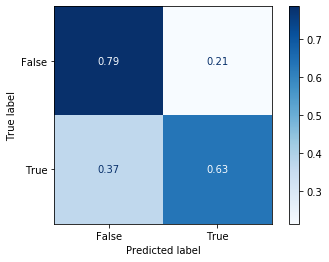

In [181]:
gb_clf2 = GradientBoostingClassifier(n_estimators=280, learning_rate=1, max_features=2, max_depth=9, random_state=0)
gb_clf2.fit(X_train, y_train)

y_pred = gb_clf2.predict(X_test)

metrics.plot_confusion_matrix(gb_clf2, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [182]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.79      0.78      4118
        True       0.65      0.63      0.64      2617

    accuracy                           0.73      6735
   macro avg       0.71      0.71      0.71      6735
weighted avg       0.73      0.73      0.73      6735



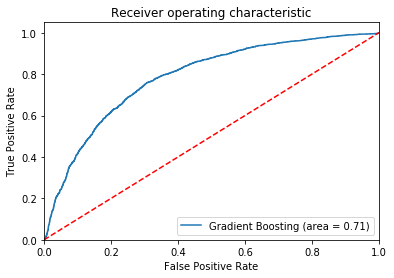

In [183]:
logit_roc_auc = roc_auc_score(y_test, gb_clf2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb_clf2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()